In [1]:
from ase.build import bulk
from ase.calculators.emt import EMT
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from phonopy.units import VaspToTHz

from atomistics.calculators.ase import evaluate_with_ase
from atomistics.workflows.quasiharmonic.workflow import QuasiHarmonicWorkflow

In [2]:
workflow = QuasiHarmonicWorkflow(
    structure=bulk("Al", a=4.0, cubic=True),
    num_points=11,
    vol_range=0.05,
    interaction_range=10,
    factor=VaspToTHz,
    displacement=0.01,
    dos_mesh=20,
    primitive_matrix=None,
    number_of_snapshots=None,
)

In [3]:
structure_dict = workflow.generate_structures()

In [4]:
result_dict = evaluate_with_ase(task_dict=structure_dict, ase_calculator=EMT())

In [5]:
eng_internal_dict, mesh_collect_dict, dos_collect_dict = \
 workflow.analyse_structures(output_dict=result_dict)

In [6]:
tp_collect_dict = workflow.get_thermal_properties(
    t_min=1, t_max=1500, t_step=50, temperatures=None
)

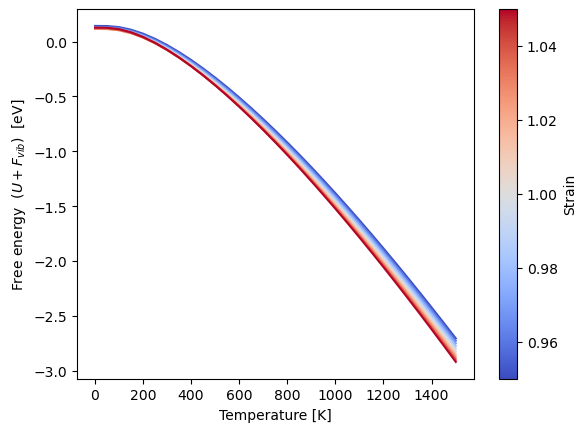

In [7]:
strain_max = max(tp_collect_dict.keys())
strain_min = min(tp_collect_dict.keys())

cmap = matplotlib.colormaps['coolwarm']

fig, ax = plt.subplots()
for strain, thermal_dict in tp_collect_dict.items():
    color = cmap((strain-strain_min)/(strain_max-strain_min))
    ax.plot(
        thermal_dict['temperatures'], 
        thermal_dict['free_energy'] + eng_internal_dict[strain], 
        label=str(strain), color=color
    )
ax.set_xlabel("Temperature [K]")
ax.set_ylabel("Free energy  ($U + F_{vib}$)  [eV]")

normalize = matplotlib.colors.Normalize(vmin=strain_min, vmax=strain_max)
scalarmappaple = matplotlib.cm.ScalarMappable(norm=normalize, cmap=cmap)
scalarmappaple.set_array(list(tp_collect_dict.keys()))
cbar = plt.colorbar(mappable=scalarmappaple, ax=ax)
cbar.set_label("Strain")

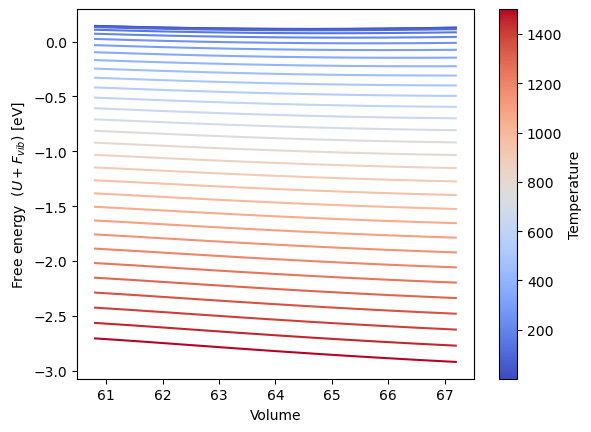

In [8]:
temperatures = tp_collect_dict[1.0]['temperatures']
temperature_max = max(temperatures)
strain_lst = eng_internal_dict.keys()
volume_lst = workflow.get_volume_lst()
eng_int_lst = np.array(list(eng_internal_dict.values()))

fig, ax = plt.subplots()
for i, temp in enumerate(temperatures):
    ax.plot(
        volume_lst, 
        np.array([tp_collect_dict[s]['free_energy'][i] for s in strain_lst]) + eng_int_lst, 
        color=cmap(temp/temperature_max)
    )
ax.set_xlabel("Volume")
ax.set_ylabel("Free energy  ($U + F_{vib}$) [eV]")

normalize = matplotlib.colors.Normalize(vmin=min(temperatures), vmax=max(temperatures))
scalarmappaple = matplotlib.cm.ScalarMappable(norm=normalize, cmap=cmap)
scalarmappaple.set_array(temperatures)
cbar = plt.colorbar(mappable=scalarmappaple, ax=ax)
cbar.set_label("Temperature")